Electricity Demand Prediction using ARMA and ARIMA Models

In [ ]:
# Some of the code in this notebook is adapted from assignments in Professor Qiaozhu Mei's course Data Mining II (SIADS 632)
# at the University of Michigan - School of Information

In [ ]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
%matplotlib inline


The following data was downloaded from the U.S. Energy Information Administration website(eia.gov). The data is from the Los Angeles Department of Water and Power.

In [ ]:
# read in csv
la_aug_2021 = pd.read_csv('LA_Aug_2021_hourly_demand.csv', header=0)
# clean time column
la_aug_2021['Timestamp (Hour Ending)'] = la_aug_2021['Timestamp (Hour Ending)'].str.rstrip('PDT')
# convert to datetime
la_aug_2021['datetime']= pd.to_datetime(la_aug_2021['Timestamp (Hour Ending)'])
print(la_aug_2021.head(2))
print(la_aug_2021.shape)

  BA Code Timestamp (Hour Ending)  Demand (MWh)  Demand Forecast (MWh)  \
0    LDWP       8/1/2021 12 a.m.           3281                 2957.0   
1    LDWP        8/1/2021 1 a.m.           3278                 2975.0   

   Net Generation (MWh)  Total Interchange (MWh)            datetime  
0                  3102                     -179 2021-08-01 00:00:00  
1                  2698                     -580 2021-08-01 01:00:00  
(745, 7)


In [ ]:
# make a series with a datetime index
la_ser=la_aug_2021[['datetime', 'Demand (MWh)']]
la_ser.index = la_ser['datetime']
la_ser = la_ser.drop(columns=['datetime'])

print(la_ser.head(2))
print(la_ser.shape)

                     Demand (MWh)
datetime                         
2021-08-01 00:00:00          3281
2021-08-01 01:00:00          3278
(745, 1)


In [ ]:
# split series into two so we have somthing to predict
la_ser_end = la_ser[577:]
print(la_ser_end.head(2))

la_ser_beg = la_ser[:577]
print(la_ser_beg.tail(2))


                     Demand (MWh)
datetime                         
2021-08-25 01:00:00          2972
2021-08-25 02:00:00          2856
                     Demand (MWh)
datetime                         
2021-08-24 23:00:00          3258
2021-08-25 00:00:00          3002


In [ ]:
# this function takes in a series and returns the rolling mean and the rolling std for a window of size wd_size

def calc_rolling_stats(ser, wd_size=7):

    rolling_mean, rolling_std = None, None

    rolling_mean = ser.rolling(wd_size).mean()
    rolling_std = ser.rolling(wd_size).std(ddof=0)

    return rolling_mean, rolling_std

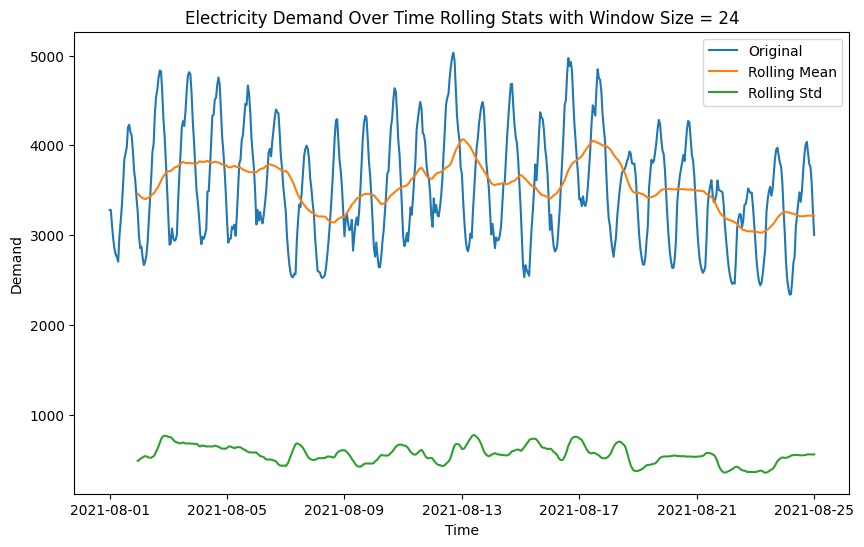

In [ ]:
# plot time series with rolling mean and sd

ser, wd_size = la_ser_beg, 24
rolling_mean, rolling_std = calc_rolling_stats(ser, wd_size)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ser, label="Original")
ax.plot(rolling_mean, label="Rolling Mean")
ax.plot(rolling_std, label="Rolling Std")

ax.set_xlabel("Time")
ax.set_ylabel("Demand")
ax.set_title("Electricity Demand Over Time " + f"Rolling Stats with Window Size = {wd_size}")
ax.legend()

del fig, ax, ser, wd_size, rolling_mean, rolling_std

ARIMA assumes that the time series data is stationary, which means its statistical properties (mean, variance, autocorrelation) do not change over time. If the data is not stationary, it needs to be transformed to achieve stationarity.

This data is not stationary, as can be seen in the figure above.

In [ ]:
# this function takes in a series and computes the log return
# the default behavior of .diff() is to calculate the difference of a DataFrame element compared with
# the element in previous row

def calc_log_ret(ser):

    log_ret = None
    log_ret = np.log(ser)
    log_ret = log_ret.diff()
    log_ret.dropna(inplace=True)
    return log_ret

Log return is a common transformation applied to time series data, especially in financial analysis. It measures the proportional change in the logarithm of a variable over a specific time interval. By taking the logarithm of the variable, we convert multiplicative changes into additive changes, which can be easier to analyze.

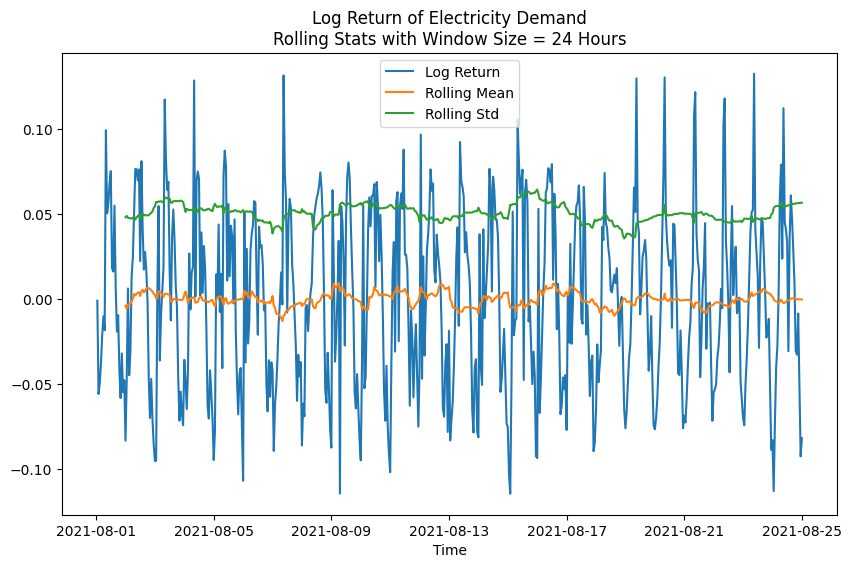

In [ ]:
# plot the rolling statistics after applying log return function

log_ret, wd_size = calc_log_ret(la_ser_beg), 24
rolling_mean, rolling_std = calc_rolling_stats(log_ret, wd_size)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(log_ret, label="Log Return")
ax.plot(rolling_mean, label="Rolling Mean")
ax.plot(rolling_std, label="Rolling Std")

ax.set_xlabel("Time")
ax.set_title("Log Return of Electricity Demand\n" + f"Rolling Stats with Window Size = {wd_size} Hours")
ax.legend()

del fig, ax, log_ret, wd_size, rolling_mean, rolling_std

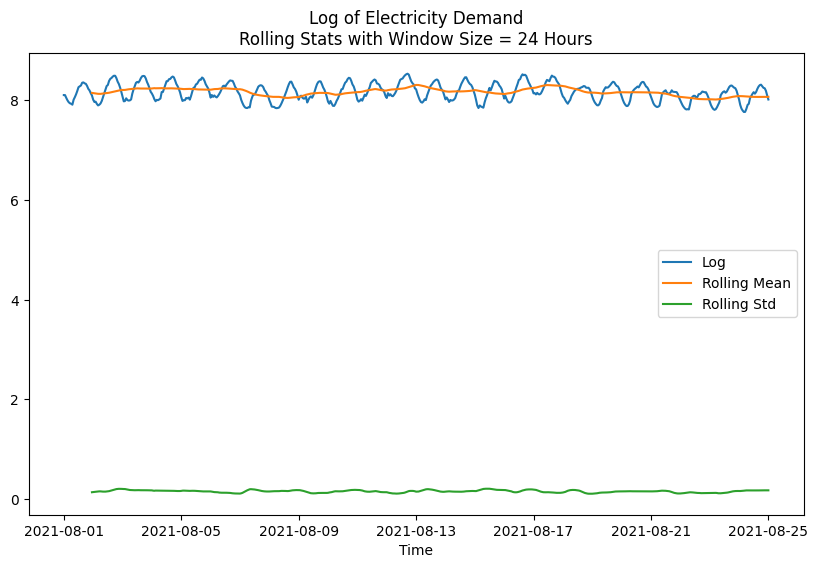

In [ ]:
# plot the rolling statistics after applying log  function

log_only, wd_size = np.log(la_ser_beg), 24
rolling_mean, rolling_std = calc_rolling_stats(log_only, wd_size)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(log_only, label="Log")
ax.plot(rolling_mean, label="Rolling Mean")
ax.plot(rolling_std, label="Rolling Std")

ax.set_xlabel("Time")
ax.set_title("Log of Electricity Demand\n" + f"Rolling Stats with Window Size = {wd_size} Hours")
ax.legend()

del fig, ax, log_only, wd_size, rolling_mean, rolling_std

In [ ]:
print(la_ser_beg.tail(2))
print(la_ser_end.shape)

                     Demand (MWh)
datetime                         
2021-08-24 23:00:00          3258
2021-08-25 00:00:00          3002
(168, 1)


In [ ]:
print(calc_log_ret(la_ser_beg).tail(2))

                     Demand (MWh)
datetime                         
2021-08-24 23:00:00     -0.092572
2021-08-25 00:00:00     -0.081835


Autocorrelation is a measure of the relationship between a variable and its lagged values. It quantifies the degree of similarity between a data point and its previous observations at different time lags. In other words, autocorrelation captures the presence of any patterns, trends, or dependencies in the time series data.

In [ ]:
from statsmodels.tsa.stattools import acf

def calc_acf(ser, max_lag):
    ans_acf = acf(ser, nlags=max_lag)
    return ans_acf

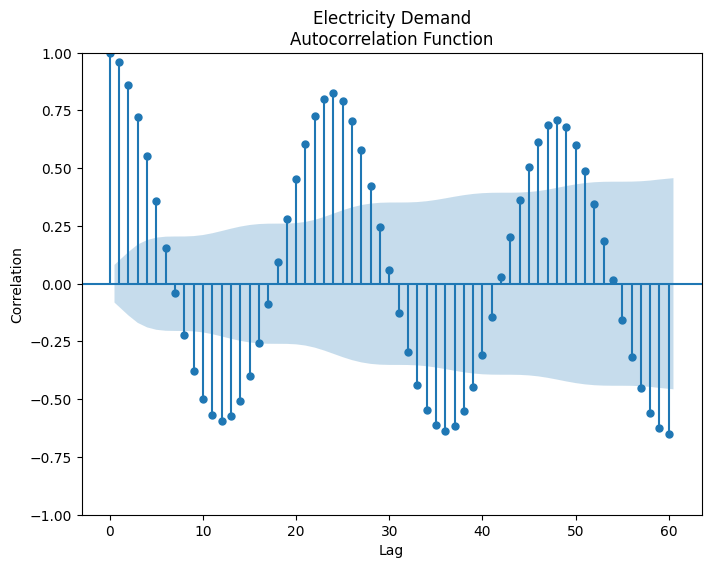

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

ser, max_lag = la_ser_beg, 60

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plot_acf(ser, ax, lags=max_lag, title="Electricity Demand\nAutocorrelation Function")
ax.set_xlabel(r"Lag")
ax.set_ylabel(r"Correlation")

del fig, ax, ser, max_lag, plot_acf

As we might expect, electricity demand exhibits a daily pattern so demand at the same time each day shows a high positive correlation.

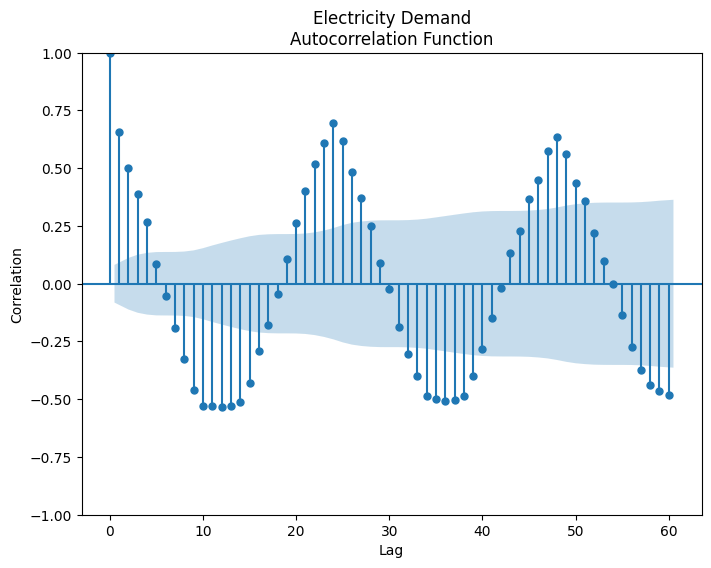

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

ser, max_lag = calc_log_ret(la_ser_beg), 60

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plot_acf(ser, ax, lags=max_lag, title="Electricity Demand\nAutocorrelation Function")
ax.set_xlabel(r"Lag")
ax.set_ylabel(r"Correlation")

del fig, ax, ser, max_lag, plot_acf

In [ ]:
from statsmodels.tsa.stattools import pacf

#this function takes a series and calculates the PACF

def calc_pacf(ser, max_lag):

    ans_pacf = None
    ans_pacf = pacf(ser, nlags=max_lag)

    return ans_pacf

The Partial Autocorrelation Function (PACF) is a tool used in time series analysis to identify the direct relationship between a variable and its lagged values while controlling for the influence of intermediate lags. It helps to determine the optimal lag order for autoregressive (AR) models.

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0, 0.5, 'Correlation')

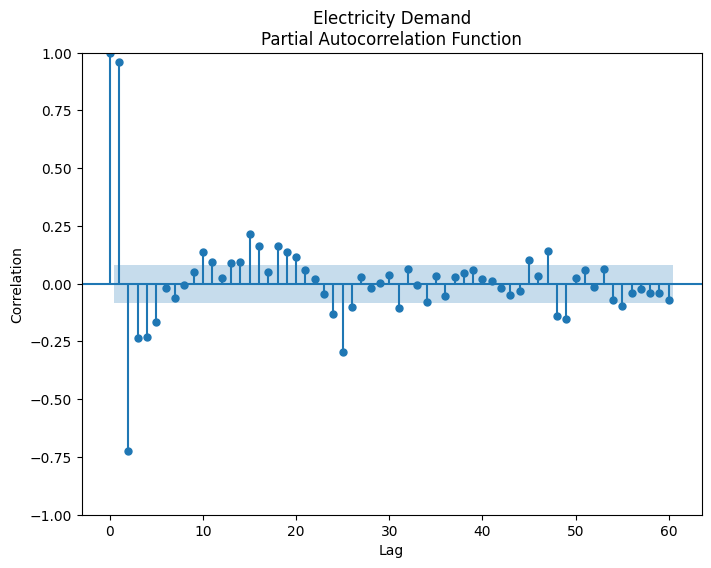

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

ser, max_lag = la_ser_beg, 60

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plot_pacf(ser, ax, lags=max_lag, title="Electricity Demand\nPartial Autocorrelation Function")
ax.set_xlabel(r"Lag")
ax.set_ylabel(r"Correlation")

del fig, ax, ser, max_lag, plot_pacf

Autoregressive Integrated Moving Average (ARIMA) model is a popular method for analyzing and predicting future values based on historical data. ARIMA combines three key components: autoregression (AR), differencing (I), and moving average (MA).

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


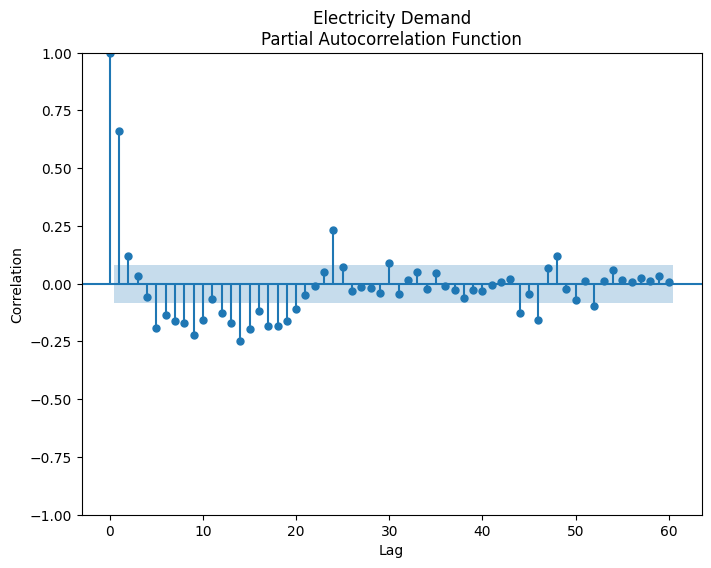

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

ser, max_lag = calc_log_ret(la_ser_beg), 60

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plot_pacf(ser, ax, lags=max_lag, title="Electricity Demand\nPartial Autocorrelation Function")
ax.set_xlabel(r"Lag")
ax.set_ylabel(r"Correlation")

del fig, ax, ser, max_lag, plot_pacf

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

def arima_model(ser, p, d, q, num_forecasts):
    """
    Takes a series and fits an ARMA(p,d, q) model.
    Returns a number of forecasts as specified by num_forecasts.
    """
    # p = maximum lags for autoregression
    # d = difference order
    # q = window size of moving average

    forecasts = None

    mod = ARIMA(ser, order=(p, d, q), freq='H', enforce_stationarity=False, enforce_invertibility=False)
    res = mod.fit()
    forecasts = res.forecast(steps=num_forecasts)
    #print(res.summary())
    return forecasts

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


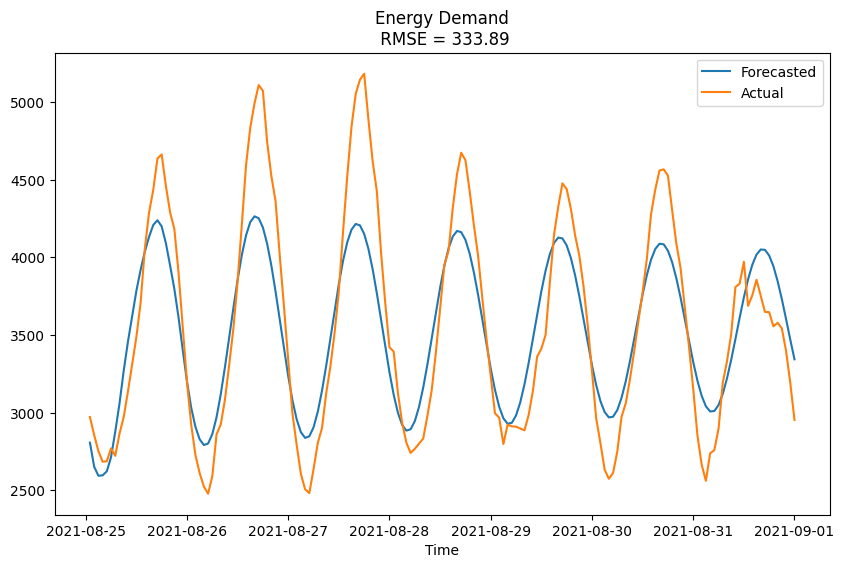

In [ ]:
ser = la_ser_beg
p, d, q, num_forecasts = 6, 0, 24, 168

forecasts = arima_model(ser, p, d, q, num_forecasts)
actual = la_ser_end['Demand (MWh)']

rmse = np.sqrt(np.mean((actual.subtract(forecasts)** 2)))
rmse = round(rmse, 2)
#print(rmse)

fig, ax = plt.subplots(figsize=(10, 6))
#ax.plot(ser, label="Original")
ax.plot(forecasts, label="Forecasted")
ax.plot(actual, label="Actual")

ax.set_xlabel("Time")
ax.set_title("Energy Demand\n" + f" RMSE = {rmse}")
ax.legend()

del fig, ax, ser, p, q, num_forecasts, forecasts, actual

This looks pretty good. Differencing is set to 0 so this is just a ARMA model. The model produces predictions that are close to actual values but it fails to predict the highest and lowest demand values accurately.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


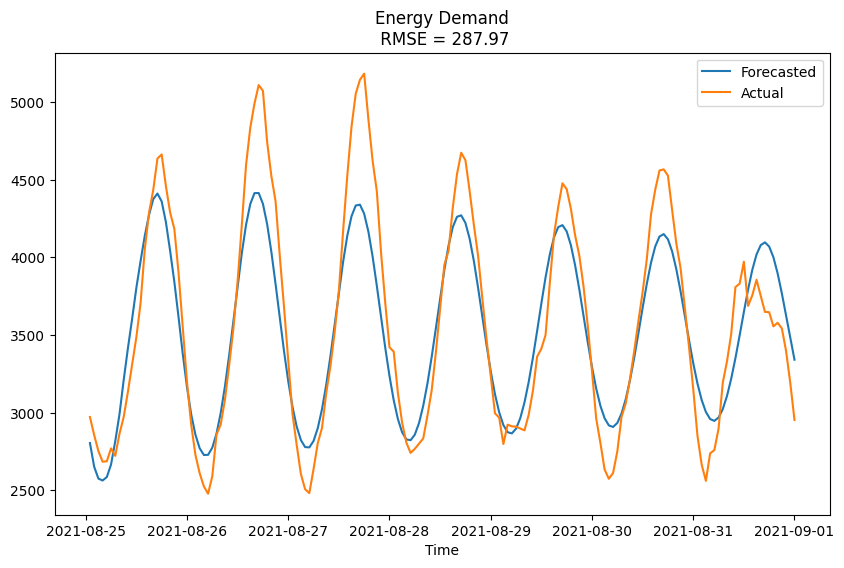

In [ ]:
ser = np.log(la_ser_beg)
p, d, q, num_forecasts = 6, 0, 24, 168

forecasts = arima_model(ser, p, d, q, num_forecasts)
forecasts = np.exp(forecasts)
actual = la_ser_end['Demand (MWh)']

rmse = np.sqrt(np.mean((actual.subtract(forecasts)** 2)))
rmse = round(rmse, 2)
#print(rmse)

fig, ax = plt.subplots(figsize=(10, 6))
#ax.plot(ser, label="Original")
ax.plot(forecasts, label="Forecasted")
ax.plot(actual, label="Actual")

ax.set_xlabel("Time")
ax.set_title("Energy Demand\n" + f" RMSE = {rmse}")
ax.legend()

del fig, ax, ser, p, q, num_forecasts, forecasts, actual

In this model run the input values were log transformed. Differencing was still set to 0. Predictions improved especially around high and low demand values.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


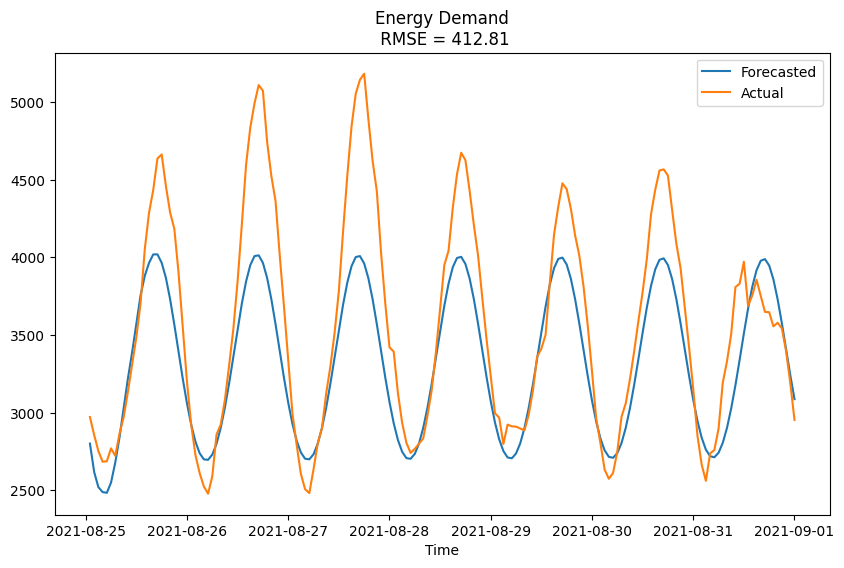

In [ ]:
ser = np.log(la_ser_beg)
p, d, q, num_forecasts = 6, 1, 24, 168

forecasts = arima_model(ser, p, d, q, num_forecasts)
forecasts = np.exp(forecasts)
actual = la_ser_end['Demand (MWh)']

rmse = np.sqrt(np.mean((actual.subtract(forecasts)** 2)))
rmse = round(rmse, 2)
#print(rmse)

fig, ax = plt.subplots(figsize=(10, 6))
#ax.plot(ser, label="Original")
ax.plot(forecasts, label="Forecasted")
ax.plot(actual, label="Actual")

ax.set_xlabel("Time")
ax.set_title("Energy Demand\n" + f" RMSE = {rmse}")
ax.legend()

del fig, ax, ser, p, q, num_forecasts, forecasts, actual

As you can see in the figure above, a log transformation combined with first order differencing resulted in worse predictions than a log transformation alone.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


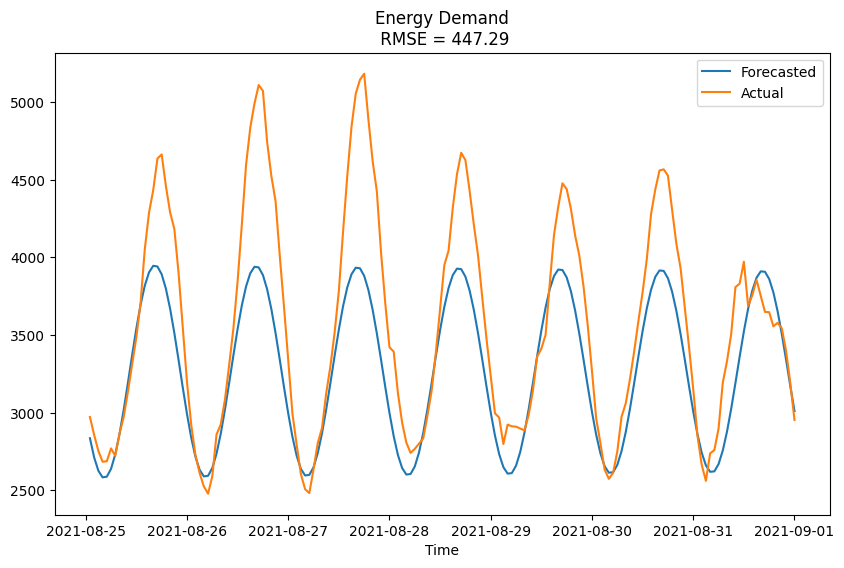

In [ ]:
#use for log transform
#ser = np.log(la_ser_beg)

ser = la_ser_beg

p, d, q, num_forecasts = 3, 1, 4, 168

forecasts = arima_model(ser, p, d, q, num_forecasts)

#use for log transform
#forecasts = np.exp(forecasts)

actual = la_ser_end['Demand (MWh)']

rmse = np.sqrt(np.mean((actual.subtract(forecasts)** 2)))
rmse = round(rmse, 2)
#print(rmse)

fig, ax = plt.subplots(figsize=(10, 6))
#ax.plot(ser, label="Original")
ax.plot(forecasts, label="Forecasted")
ax.plot(actual, label="Actual")

ax.set_xlabel("Time")
ax.set_title("Energy Demand\n" + f" RMSE = {rmse}")
ax.legend()

del fig, ax, ser, p, q, num_forecasts, forecasts, actual